En este codigo se programa eficientemente una solucion al problema lasso

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Functions 

## Optimization functions

https://stanford.edu/~jduchi/projects/DuchiShSiCh08.pdf 

In [2]:
def ERM(A, b, n, x):
  return (1/n)*np.sum([loss(A[i], b[i], x) for i in range(n)])

def ERM_gradient(A, b, n, d, x):
  g = np.zeros(d)
  for i in range(n):
    g+= loss_gradient(A[i], b[i], x)
  return (1/n)*g

def loss(a,b,x):
  return (np.dot(a,x)-b)**2

def loss_gradient(a,b,x):
  return 2*(np.dot(a,x)-b)*a

def proyeccion_L1_no_neg(x,R,dim):
  if np.linalg.norm(x, ord = 1) <= R:
    return x
  ordenado = -np.sort(-x, kind = 'mergesort')
  p = 1
  b = 0
  for i in range(1,dim+1):
    act = dim-i
    b = np.sum(ordenado[:act+1]) - R
    if ordenado[act] > b/(act+1):
      p = act+1
      break 
  theta = b/p 
  return (x-theta).clip(min = 0) 

def L1_projection(x,R,dim):
  u = abs(x)
  beta = proyeccion_L1_no_neg(u,R,dim)
  return np.sign(x)*beta

## Privacy functions

In [3]:
#https://programming-dp.com/notebooks/ch5.html
def gaussian_mech(vec, sigma):
    return np.array([v + np.random.normal(loc=0, scale=sigma) for v in vec])

def laplace_mech(v, scale):
    return v + np.random.laplace(loc=0, scale=scale)

def report_noisy_max(dim, d, s, scale):

    noisy_scores = np.zeros(2*dim)
    for i in range(dim):
      noisy_scores[2*i] = laplace_mech(s*d[i] , scale)
      noisy_scores[2*i + 1] = laplace_mech(-s*d[i] , scale)
    min_idx = np.argmin(noisy_scores)
    # Return the coordinate 
    return min_idx

## Dataset generation functions

Now that we know how to generate $x^*$, we'd like to generate datasets such that we solve the problem in the realizable case.

In [4]:
def uniform_subset_sampling(L,l,s):
  """
  Input: List L of lenght l, and a parameter s
  Output: subset of L of size s.
  """
  selected_indexes = []
  t = 0 
  d = 0
  while d<s:
    u = np.random.random()
    if u <= (s-d)/(l-t):
      selected_indexes.append(t)
      d+=1
    t+=1
  return selected_indexes

def generate_hypothesis_vec(d,s):
  """
  Returns x* for the realizable case, where d is dimension
  and s is sparsity level. 
  """
  selected_positions = uniform_subset_sampling(list(range(d)),d,s)
  return np.array([np.random.choice([1,-1]) if i in selected_positions else 0 for i in range(d)])

def fast_generate_dataset(x_star, n, d, L=1):
  """
  Generates a valid dataset
  """
  A = 2*L*np.random.rand(n, d) - L
  b = A.dot(x_star)
  return A, b

# Class Experiment + example 

## Code

In [22]:
class Experiment(object):

  def __init__(self, n, epsilon, delta, s, L=1):
    self.n = n
    self.epsilon = epsilon 
    self.delta = delta
    self.s = s
    self.L = L
    self.L0 = 4*L**2*s
    self.L1 = 2*L**2
    self.sfw_results = dict()
    self.sgd_results = dict()

  def full_batch_polySFW(self, A, b, A_test, b_test, test_size, d):
    #https://arxiv.org/pdf/1411.5417.pdf algorithm 4

    T = int((4*self.L**2*self.s**2*self.n*epsilon/(self.s*self.L0))**(2/3)) #curvatura se puede acotar por suavidad y radio de la bola
    x = np.zeros(d) 
    for t in range(T):
      gradient = ERM_gradient(A, b, self.n, d, x)
      alpha_t = report_noisy_max(d, gradient, self.s, self.L0*self.s*np.sqrt(8*T*np.log(1/self.delta))/(self.n*self.epsilon))
      x = (1-1/(T+2))*x 
      x[alpha_t//2] += self.s*(1-2*(alpha_t%2))*(1/(T+2))
    return ERM(A_test,b_test,test_size,x)
 
  
  def PhasedSGD(self, A, b, A_test, b_test, test_size, dim, L=1):

    #https://arxiv.org/pdf/2005.04763.pdf algorithm 2

    rho = -np.sqrt(2*np.log(1/self.delta)) + np.sqrt(2*np.log(1/self.delta) + 2*self.epsilon)
    eta = (np.sqrt(dim)/self.L0)*np.min([4/np.sqrt(self.n), rho/np.sqrt(dim)])
    wi = np.zeros(dim)
    k = int(np.ceil(np.log2(n)))
    current = 0
    for i in range(1,k+1):
      ni = int(n*2**(-i))
      etai = eta*4**(-i)
      xi = self._PSGD(A, b, current, wi, etai, ni, dim, L)
      current+= ni
      wi = gaussian_mech(xi/(i+1) + i*wi/(i+1), 4*self.L0*etai/rho) 
      
    return ERM(A_test,b_test,test_size,L1_projection(wi,self.s-10**(-14),dim))
    #return ERM(A_test,b_test,test_size,wi)

    
  def _PSGD(self, A, b, current, w0, eta, T, dim, L):
    w = w0
    for j in range(current, current + T):
      gradient = loss_gradient(A[j],b[j],w)
      w = L1_projection(w - eta*gradient,self.s-10**(-14),dim)
    return w
  
  def polySFW(self, A, b, A_val, b_val, val_size, A_test, b_test, test_size, n, epsilon, delta, dim, L=1):
    
    #https://arxiv.org/abs/2103.01278 algorithm 1
    
    x_old = np.zeros(dim) 
    x_min = x_old
    min = ERM(A_val,b_val,val_size, x_old)
    eta = np.log(n/np.log(2*dim))/n 
    d = ERM_gradient(A[0:int(n/2),], b[0:int(n/2)], int(n/2), dim, x_old)
    alpha_0 = report_noisy_max(dim, d, self.s, 4*self.L0*self.s*np.sqrt(np.log(1/delta))/(np.sqrt(n)*epsilon))
    x_new = (1-eta)*x_old 
    x_new[alpha_0//2] += eta*self.s
    _min = ERM(A_val,b_val,val_size, x_new)
    if _min<min:
      x_min = x_new
    for t in range(1,int(n/2)):
      st = np.max([(1-eta)**t*2*self.L0*self.s/n, 2*eta*self.s*(self.L1*self.s+self.L0)])
      _a,_b = A[int(n/2)+(t-1),] , b[int(n/2)+(t-1)]
      gradient_old = loss_gradient(_a,_b, x_old)
      gradient_new = loss_gradient(_a,_b, x_new)
      gradient_variation = gradient_new - gradient_old
      d = (1-eta)*(d + gradient_variation) + eta*gradient_new
      alpha_t = report_noisy_max(dim, d, self.s, 2*(st)*np.sqrt(n*np.log(1/delta))/epsilon)
      x_new, x_old = (1-eta)*x_old, x_new
      x_new[alpha_t//2] += eta*self.s
      _min = ERM(A_val,b_val,val_size, x_new)
      if _min<min:
        x_min = x_new
    
    return ERM(A_test,b_test,test_size, x_min)
  
  def mini_batch_polySFW(self, A, b, A_test, b_test, test_size, n, epsilon, delta, dim, L=1):

    x_old = np.zeros(dim) 
    x_min = x_old
    min = ERM(A_test,b_test,test_size, x_old)
    eta = np.log(n/np.log(2*dim))/n 
    d = ERM_gradient(A[0:int(n/2),], b[0:int(n/2)], int(n/2), dim, x_old)
    #alpha_0 = report_noisy_max(dim, d, self.s, epsilon)
    alpha_0 = report_noisy_max(dim, d, self.s, 4*self.L0*self.s*np.sqrt(np.log(1/delta))/(np.sqrt(n)*epsilon))
    #print(4*self.L0*self.s*np.sqrt(np.log(1/delta))/(np.sqrt(n)*epsilon))
    x_new = (1-eta)*x_old 
    x_new[alpha_0//2] += eta*self.s
    _min = ERM(A_test,b_test,test_size, x_new)
    if _min<min:
      x_min = x_new
    for t in range(1,int(n/128)):
      st = np.max([(1-eta)**t*2*self.L0*self.s/n, 2*eta*self.s*(self.L1*self.s+self.L0)])
      _a,_b = A[int(n/2)+(t-1):int(n/2)+(t-1) + 64 ,] , b[int(n/2)+(t-1):int(n/2)+(t-1) + 64]
      gradient_old = ERM_gradient(_a,_b, 1, dim, x_old)
      gradient_new = ERM_gradient(_a,_b, 1, dim, x_new)
      gradient_variation = gradient_new - gradient_old
      d = (1-eta)*(d + gradient_variation) + eta*gradient_new
      alpha_t = report_noisy_max(dim, d, self.s, 2*(st/64)*np.sqrt(n*np.log(1/delta))/epsilon)
      x_new, x_old = (1-eta)*x_old, x_new
      x_new[alpha_t//2] += eta*self.s
      _min = ERM(A_test,b_test,test_size, x_new)
    if _min<min:
      x_min = x_new
    
    return ERM(A_test,b_test,test_size, x_min), _min
    

## Example 

First we set the parameters that are common to all experiments

In [23]:
n = 512
s = 15
epsilon = 2
delta = 10**(-2)
experiment = Experiment(n, epsilon, delta, s)
val_size = 1000
test_size = 1000

now we set the parameters that depend on the dimension

In [28]:
d = 2**10
x_star = generate_hypothesis_vec(d,s)
A, b = fast_generate_dataset(x_star,n,d)
A_test, b_test = fast_generate_dataset(x_star,test_size,d)
A_val,b_val = fast_generate_dataset(x_star,val_size,d)

we run Private Polyhedral Frank-Wolfe

In [30]:
experiment.polySFW(A, b, A_val, b_val, val_size, A_test, b_test, test_size, n, epsilon, delta, d)

5.356657105029687

and finally we run Phased SGD

In [29]:
experiment.PhasedSGD(A, b, A_test, b_test, test_size, d)

27.695493398414882

# Experiment 

In [32]:
n = 2**10
s = 10
epsilon = 0.1
delta = 10**(-3)
val_size = 100
test_size = 100
experiment = Experiment(n, epsilon, delta, s)

In [37]:
from IPython.display import clear_output

for i in range(6,15):
  print(f'dimension {2**i}')
  d = 2**i
  for j in range(10):
    print(f'j = {j}')
    x_star = generate_hypothesis_vec(d,s)
    x_star = generate_hypothesis_vec(d,s)
    A, b = fast_generate_dataset(x_star,n,d)
    A_test, b_test = fast_generate_dataset(x_star,test_size,d)
    A_val,b_val = fast_generate_dataset(x_star,val_size,d)
    sfw_test = experiment.polySFW(A, b, A_val, b_val, val_size, A_test, b_test, test_size, n, epsilon, delta, d)
    experiment.sfw_results[(i,j)] = sfw_test
    sgd_test = experiment.PhasedSGD(A, b, A_test, b_test, test_size, d)
    experiment.sgd_results[(i,j)] = sgd_test
clear_output()

In [38]:
experiment.sfw_results

{(6, 0): 2.9434109512325164,
 (6, 1): 3.354138959827856,
 (6, 2): 2.9073263506582565,
 (6, 3): 2.780038218396106,
 (6, 4): 3.217787754697688,
 (6, 5): 2.642110232374879,
 (6, 6): 4.07690874604328,
 (6, 7): 3.6948629214366946,
 (6, 8): 2.8036559152263885,
 (6, 9): 2.8548481184730496,
 (7, 0): 3.017200525891715,
 (7, 1): 3.1160409996487277,
 (7, 2): 4.190844885732742,
 (7, 3): 2.3944761821278138,
 (7, 4): 3.0890473137963306,
 (7, 5): 3.227303776412681,
 (7, 6): 3.6253818675793457,
 (7, 7): 3.0625569622674393,
 (7, 8): 3.319627418162886,
 (7, 9): 2.7769097093434976,
 (8, 0): 3.4943343450039213,
 (8, 1): 3.7956336816505227,
 (8, 2): 3.460308992917354,
 (8, 3): 3.8198672976864674,
 (8, 4): 3.2915473168424403,
 (8, 5): 3.4827765340261574,
 (8, 6): 2.761568498746467,
 (8, 7): 2.85410696881633,
 (8, 8): 3.605140061903949,
 (8, 9): 3.769358311330858,
 (9, 0): 3.969839104280531,
 (9, 1): 3.7283359161840184,
 (9, 2): 3.449569842944123,
 (9, 3): 3.3315233211169564,
 (9, 4): 3.4438627126965176,
 (9

In [39]:
experiment.sgd_results

{(6, 0): 8.86061497264813,
 (6, 1): 8.592354451749035,
 (6, 2): 8.62258528832317,
 (6, 3): 5.1487844485980405,
 (6, 4): 7.4467269210335,
 (6, 5): 10.531768982423673,
 (6, 6): 10.4083371377098,
 (6, 7): 9.114325015469886,
 (6, 8): 6.765052895313588,
 (6, 9): 7.4492710194996805,
 (7, 0): 10.907849600973366,
 (7, 1): 7.8013693175248084,
 (7, 2): 13.187699482873025,
 (7, 3): 10.777083639546177,
 (7, 4): 9.978419995772471,
 (7, 5): 11.209786797941021,
 (7, 6): 11.655523396840568,
 (7, 7): 11.700382671484242,
 (7, 8): 6.87683968202908,
 (7, 9): 6.483308313657063,
 (8, 0): 12.955325137892071,
 (8, 1): 12.675176973436022,
 (8, 2): 10.959242783931588,
 (8, 3): 8.388572738247948,
 (8, 4): 10.235602743973214,
 (8, 5): 10.628100029704635,
 (8, 6): 8.247293705680358,
 (8, 7): 11.39402076687359,
 (8, 8): 14.079340852278063,
 (8, 9): 14.587402465239537,
 (9, 0): 15.03566215306801,
 (9, 1): 14.200560132827407,
 (9, 2): 16.10773886822073,
 (9, 3): 16.68319333598054,
 (9, 4): 15.19323007415372,
 (9, 5):

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


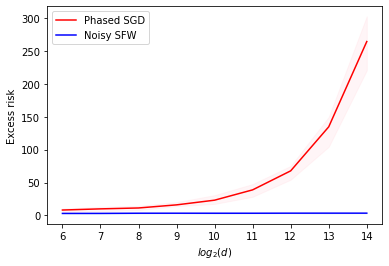

In [41]:
sfw_mean = np.array([np.mean([experiment.sfw_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sfw_max = np.array([np.max([experiment.sfw_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sfw_min = np.array([np.min([experiment.sfw_results[(i,j)] for j in range(10)]) for i in range(6,15)])

sgd_mean = np.array([np.mean([experiment.sgd_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sgd_max = np.array([np.max([experiment.sgd_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sgd_min = np.array([np.min([experiment.sgd_results[(i,j)] for j in range(10)]) for i in range(6,15)])


plt.plot(range(6,15), sgd_mean, color = 'r', label = 'Phased SGD')
plt.fill_between(range(6,15), sgd_min, sgd_max , color='pink', alpha=.15)
plt.plot(range(6,15), sfw_mean, color='b', label = 'Noisy SFW')
plt.fill_between(range(6,15), sfw_min, sfw_max , color='lightblue', alpha=.15)
plt.ylabel('Excess risk')
plt.xlabel('$log_2(d)$')
plt.legend()
plt.savefig('/content/drive/MyDrive/Universidad/quinto año/ipre/final_error_ipre.eps', format='eps')
plt.show()  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


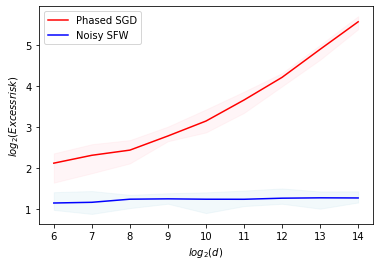

In [45]:
sfw_mean = np.array([np.mean([experiment.sfw_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sfw_max = np.array([np.max([experiment.sfw_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sfw_min = np.array([np.min([experiment.sfw_results[(i,j)] for j in range(10)]) for i in range(6,15)])

sgd_mean = np.array([np.mean([experiment.sgd_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sgd_max = np.array([np.max([experiment.sgd_results[(i,j)] for j in range(10)]) for i in range(6,15)])
sgd_min = np.array([np.min([experiment.sgd_results[(i,j)] for j in range(10)]) for i in range(6,15)])

plt.plot(range(6,15), np.log(sgd_mean), color = 'r', label = 'Phased SGD')
plt.fill_between(range(6,15), np.log(sgd_min), np.log(sgd_max) , color='pink', alpha=.15)
plt.plot(range(6,15), np.log(sfw_mean), color='b', label = 'Noisy SFW')
plt.fill_between(range(6,15), np.log(sfw_min), np.log(sfw_max) , color='lightblue', alpha=.15)
plt.ylabel('$log_2(Excess risk)$')
plt.xlabel('$log_2(d)$')
plt.legend()
plt.savefig('/content/drive/MyDrive/Universidad/quinto año/logerror_ipre.eps', format='eps')
#plt.savefig('logdlogerror.svg', format='svg', dpi=1200)
#plt.ylim(-2,1)
plt.show()  